# Downloading LandSat 8 in Ho Chi Minh City (HCMC) with Google Earth Engine

**Prerequisites:**
1. [A Google account](https://accounts.google.com/).
2. [A Google Earth Engine project](https://code.earthengine.google.com/register) – make sure to record your project ID for later use.

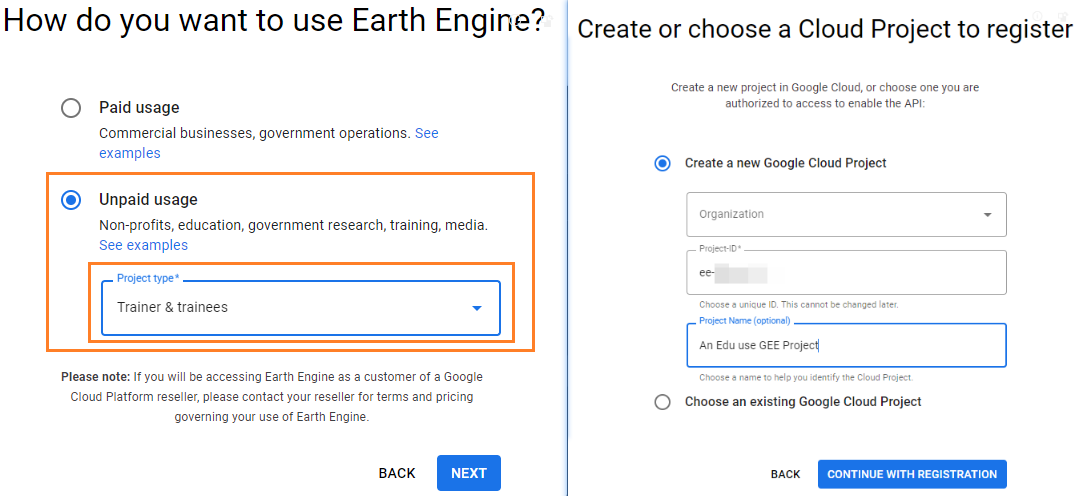

Install geemap.

%alias is a [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) for system command.

In [ ]:
# uncomment it to install geemap
# %pip install geemap
# %pip install geedim

In [ ]:
import os
import ee
import geemap
from geemap.datasets import DATA

If you are using Google Colab, you need to mount Google Drive to your notebook. So the Google Drive is able to read and wirte the data stored in the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Create a project on the Google Earth Engine, and record the name of your project and input here:

In [ ]:
ee.Authenticate()
ee.Initialize(project="e-tuner-297119") # Change to your project ID here

Short code to check how it looks like:

In [ ]:
import geopandas as gpd
import pandas as pd

In [ ]:
# get the path from google drive to the boundary of Phnom Penh
hcmc_boundary = "../../data/raw/part_iii/HCMC_Boundary.geojson"

# read geojson as a dataframe
hcmc_boundary_df = gpd.read_file(hcmc_boundary)

hcmc_boundary_df_geojson = hcmc_boundary_df.geometry.iloc[0].__geo_interface__

In [ ]:
Map = geemap.Map()

Map.add_gdf(hcmc_boundary_df, layer_name="HCMC Boundary", zoom_to_layer = True)

Map

In [ ]:
roi = ee.Geometry.Point(106.67314112786491, 10.778701328669166) # HCMC centroid's coordinates

landsat8_ic = ee.ImageCollection("LANDSAT/LC08/C02/T1")  \
    .filterDate('2024-02-01', '2024-02-30') \
    .filterBounds(roi)

image = landsat8_ic.mean()

image = image.clip(hcmc_boundary_df_geojson)

image = image.select(['B5', 'B4'])

In [ ]:
image

In [ ]:
geemap.ee_export_image(
      image,
      filename = f"/content/drive/MyDrive/ColabNotebooks/geemap/data/lansat_hcmc_jan2024.tif",
      scale = 90,
      region = hcmc_boundary_df_geojson,
      file_per_band = False
  )

In [ ]:
landsat8_ic = ee.ImageCollection("LANDSAT/LC08/C02/T1")  \
    .filterDate('2020-01-01', '2020-01-31') \
    .filterBounds(roi)

image = landsat8_ic.mean()

# Compute the NDVI using an expression.
ndvi = image.expression(
    "((NIR - RED) / (NIR + RED))",
    {
        "NIR": image.select("B5"),
        "RED": image.select("B4"),
    },
)

ndvi_hcmc = ndvi.clip(hcmc_boundary_df_geojson)

In [ ]:
# Define a map centered on HCMC.
m = geemap.Map(center=[10.77, 106.67], zoom=9)

style = {"color": "000ffff0", "width": 2, "lineType": "solid", "fillColor": "00000000"}

vis = {"min": 0, "max": 1, "palette": "ndvi"}

m.add_layer(ndvi_hcmc, vis, "NDVI")

m.add_gdf(hcmc_boundary_df, layer_name="HCMC Boundary", zoom_to_layer = True, style = style)

m.add_colorbar(vis, label="NDVI")

m

In [ ]:
for year in range(2007, 2026):
  print(year)
  try:
    blt_surface = ee.Image(f"JRC/GHSL/P2023A/GHS_BUILT_S/{year}").select('built_surface')
    landsat8_ic = ee.ImageCollection("LANDSAT/LC08/C02/T1")  \
        .filterDate(f'{year}-01-01', f'{year}-01-31') \
        .filterBounds(roi)
    image = landsat8_ic.mean()


    # Compute the NDVI using an expression.
    ndvi = image.expression(
        "((NIR - RED) / (NIR + RED))",
        {
            "NIR": image.select("B5"),
            "RED": image.select("B4"),
        },
    )

    ndvi_hcmc = ndvi.clip(hcmc_boundary_df_geojson)

    geemap.ee_export_image(
        ndvi_hcmc.select(0), filename=f'/content/drive/MyDrive/ColabNotebooks/geemap/data/ndvi/ndvi_hcmc_{year}.tif', scale=90, region=hcmc_boundary_df_geojson, file_per_band=False
    )
    
  except:
    print(f"An exception occurred for the year {year}")
